In [1]:
import pandas as pd 
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import tree
import os
import pydotplus

os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\RGS")

# Read Data

In [2]:
df = pd.read_csv(os.getcwd()+r"\Data Files\base_dump_new2.csv")

In [3]:
df.shape

(944804, 25)

In [4]:
df.head()

,SKP_CREDIT_CASE,DECISION_OVERALL,TIME_CREATION_DATE,PRODUCT_GOODS_TYPE,PRODUCT_CREDIT_TYPE,AMT_CREDIT,POS_MAR20_GM_EXI,DP_PCT,POS_GSPN_V2,CLIENT_EMI,...,RISK_AGRF120,RISK_AGRF150,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,FLAG_1PCT_PHANTOM,DECISION_REASON_GROUP,SCORE_CB
0,280774731,Rejected,01-11-19,c_Mob_Tab,ZERO,17598,NaN,0.267,2.0,3143,...,0,0,0,0,0,0,0,0,PRELIM_RGS,710.0
1,280774739,Approved,01-11-19,c_Mob_Tab,ZERO,11990,NaN,0.334,1.0,1291,...,1,1,0,0,0,0,0,0,PRE_RGS,664.0
2,280774750,Approved,01-11-19,c_Mob_Tab,STANDARD,11299,0.092093,0.372,NaN,1526,...,1,1,0,0,0,0,0,0,PRE_RGS,1.0
3,280774847,Approved,01-11-19,c_Mob_Tab,ZERO,13099,0.009076,0.229,3.0,2340,...,1,1,0,0,0,0,0,0,PRE_RGS,710.0
4,280774867,Approved,01-11-19,c_Mob_Tab,ZERO,10289,NaN,0.265,2.0,1838,...,1,1,0,0,0,0,0,0,PRE_RGS,709.0


In [5]:
df.columns

Index(['SKP_CREDIT_CASE', 'DECISION_OVERALL', 'TIME_CREATION_DATE',
       'PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT',
       'POS_MAR20_GM_EXI', 'DP_PCT', 'POS_GSPN_V2', 'CLIENT_EMI', 'POS_TYPE',
       'SCORE_FEB19_WITH_CIBIL', 'RISK_AGRF30', 'RISK_AGRF60', 'RISK_AGRF90',
       'RISK_AGRF120', 'RISK_AGRF150', 'RISK_FPD30', 'RISK_FSPD30',
       'RISK_FSTPD30', 'RISK_FSTQPD30', 'RISK_FSTQPD60', 'FLAG_1PCT_PHANTOM',
       'DECISION_REASON_GROUP', 'SCORE_CB'],
      dtype='object')

# Define Key Variables

In [6]:
TARGET = 'RISK_FSTPD30'
DATE = 'TIME_CREATION_DATE'
SCORE = 'POS_MAR20_GM_EXI'
TRAIN_START_DATE = pd.datetime(2019,11,1)
TRAIN_END_DATE = pd.datetime(2020,8,1)
# FEATURES = ['PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT',
#        'POS_MAR20_GM_EXI', 'DP_PCT', 'POS_GSPN_V2', 'CLIENT_EMI', 'POS_TYPE',
#         'PENNY_STATUS', 'VMM_SCORE_NEW', 'VMM_SCORE_EXI', 'PAYU_RESULT']

FEATURES = ['PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT',
       'POS_MAR20_GM_EXI', 'DP_PCT', 'POS_GSPN_V2', 'CLIENT_EMI', 'POS_TYPE',
        'SCORE_CB']

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


# Clean Data

In [7]:
df[DATE] = pd.to_datetime(df[DATE],format='%d-%m-%y')
df["MONTH"] = df[DATE].dt.strftime('%y-%m')

In [8]:
df.SKP_CREDIT_CASE.nunique()

944804

In [9]:
df.MONTH.value_counts().sort_index()

19-11    131668
19-12    125590
20-01    135257
20-07     82376
20-08     94536
20-09    101483
20-10     87194
20-11    115005
20-12     71695
Name: MONTH, dtype: int64

In [10]:
df[df['DP_PCT'].isin([np.Inf,np.NaN])]

,SKP_CREDIT_CASE,DECISION_OVERALL,TIME_CREATION_DATE,PRODUCT_GOODS_TYPE,PRODUCT_CREDIT_TYPE,AMT_CREDIT,POS_MAR20_GM_EXI,DP_PCT,POS_GSPN_V2,CLIENT_EMI,...,RISK_AGRF150,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,FLAG_1PCT_PHANTOM,DECISION_REASON_GROUP,SCORE_CB,MONTH


In [11]:
df = df.dropna(subset=[SCORE,'SCORE_CB','POS_GSPN_V2'])
df = df[df.DECISION_OVERALL == 'Approved']

In [12]:
CATEGORICAL_FEATURES = [key for key in dict(df[FEATURES].dtypes) if dict(df[FEATURES].dtypes)[key] in ['object']] 

In [13]:
for x in CATEGORICAL_FEATURES:
    dummy = pd.get_dummies(df[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df = pd.concat([df, dummy], axis=1)

In [14]:
df.columns

Index(['SKP_CREDIT_CASE', 'DECISION_OVERALL', 'TIME_CREATION_DATE',
       'PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT',
       'POS_MAR20_GM_EXI', 'DP_PCT', 'POS_GSPN_V2', 'CLIENT_EMI', 'POS_TYPE',
       'SCORE_FEB19_WITH_CIBIL', 'RISK_AGRF30', 'RISK_AGRF60', 'RISK_AGRF90',
       'RISK_AGRF120', 'RISK_AGRF150', 'RISK_FPD30', 'RISK_FSPD30',
       'RISK_FSTPD30', 'RISK_FSTQPD30', 'RISK_FSTQPD60', 'FLAG_1PCT_PHANTOM',
       'DECISION_REASON_GROUP', 'SCORE_CB', 'MONTH', 'a_TW_PRODUCT_GOODS_TYPE',
       'c_Mob_Tab_PRODUCT_GOODS_TYPE', 'd_CP_PRODUCT_GOODS_TYPE',
       'e_HA_PRODUCT_GOODS_TYPE', '2X0_PRODUCT_CREDIT_TYPE',
       'STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE',
       'AP_POS_TYPE', 'Aldi_POS_TYPE', 'Satellite_POS_TYPE', 'UDAAN_POS_TYPE',
       'XNA_POS_TYPE'],
      dtype='object')

In [15]:
# FINAL_FEATURES = ['POS_MAR20_GM_EXI', 'DP_PCT', 'POS_GSPN', 'CLIENT_EMI', 'AMT_CREDIT',
#                     'a_TW_PRODUCT_GOODS_TYPE', 'c_Mob_Tab_PRODUCT_GOODS_TYPE', 'd_CP_PRODUCT_GOODS_TYPE', 
#                   'e_HA_PRODUCT_GOODS_TYPE', 'f_Furniture_PRODUCT_GOODS_TYPE', 
#                   '2X0_PRODUCT_CREDIT_TYPE', 'STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE', 
#                   'AP_POS_TYPE', 'Aldi_POS_TYPE', 'Satellite_POS_TYPE', 'UDAAN_POS_TYPE', 'XNA_POS_TYPE',
#                 'CANCELLED_PENNY_STATUS', 'IN_PROGRESS_PENNY_STATUS','REJECTED_PENNY_STATUS', 'SUCCESS_PENNY_STATUS', 
# #                 'VMM_SCORE_NEW', 'VMM_SCORE_EXI', 
#                   'ERROR_PAYU_RESULT', 'FOUND_PAYU_RESULT', 'NOT_FOUND_PAYU_RESULT']

FINAL_FEATURES = ['POS_MAR20_GM_EXI', 'AMT_CREDIT',
                'a_TW_PRODUCT_GOODS_TYPE', 'c_Mob_Tab_PRODUCT_GOODS_TYPE', 'd_CP_PRODUCT_GOODS_TYPE', 
                  'e_HA_PRODUCT_GOODS_TYPE', '2X0_PRODUCT_CREDIT_TYPE', 'STANDARD_PRODUCT_CREDIT_TYPE', 
                  'ZERO_PRODUCT_CREDIT_TYPE']

# Train Set

In [16]:
df_train = df[(df[DATE]>=(TRAIN_START_DATE))&(df[DATE]<(TRAIN_END_DATE))]

In [17]:
df_train.shape

(55467, 38)

# Decision Tree

In [18]:
df_train['DP_PCT'].isna().value_counts()

False    55467
Name: DP_PCT, dtype: int64

In [19]:
for x in df_train[FINAL_FEATURES]:
    print(df_train[x].isin([np.NaN]).value_counts())

False    55467
Name: POS_MAR20_GM_EXI, dtype: int64
False    55467
Name: AMT_CREDIT, dtype: int64
False    55467
Name: a_TW_PRODUCT_GOODS_TYPE, dtype: int64
False    55467
Name: c_Mob_Tab_PRODUCT_GOODS_TYPE, dtype: int64
False    55467
Name: d_CP_PRODUCT_GOODS_TYPE, dtype: int64
False    55467
Name: e_HA_PRODUCT_GOODS_TYPE, dtype: int64
False    55467
Name: 2X0_PRODUCT_CREDIT_TYPE, dtype: int64
False    55467
Name: STANDARD_PRODUCT_CREDIT_TYPE, dtype: int64
False    55467
Name: ZERO_PRODUCT_CREDIT_TYPE, dtype: int64


## Optimize tree depth

### Cross Validation Gini with Tree Depth

In [20]:
depth= []
for i in range(1,10):
    clf = DecisionTreeClassifier(max_depth=i, min_samples_leaf = 500)
    # Perform 7-fold cross validation 
    scores = cross_val_score(clf, df_train[FINAL_FEATURES], df_train[TARGET], cv=10,scoring='roc_auc',n_jobs=-1)
    depth.append((i,scores.mean()))
print(depth)

[(1, 0.5843246019524714), (2, 0.6614827736703918), (3, 0.6829796909349028), (4, 0.687907420596396), (5, 0.6894264164436675), (6, 0.6844438632864207), (7, 0.6789713547237812), (8, 0.6758224921426719), (9, 0.6752832422674997)]


# Fit model with best n

In [24]:
clf = DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_leaf = 500)
clf.fit(df_train[FINAL_FEATURES], df_train[TARGET])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=500, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [25]:
df["PRED_PROB"]=clf.predict_proba(df[FINAL_FEATURES])[:,1]

In [26]:
# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=FINAL_FEATURES,  
                                class_names=TARGET, proportion = True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph ---Not working due to graphViz
#Image(graph.create_png())

In [27]:
print(dot_data)
# copy this to editor window on http://www.webgraphviz.com/ to create chart

digraph Tree {
node [shape=box] ;
0 [label="POS_MAR20_GM_EXI <= 0.079\ngini = 0.047\nsamples = 100.0%\nvalue = [0.976, 0.024]\nclass = R"] ;
1 [label="POS_MAR20_GM_EXI <= 0.034\ngini = 0.038\nsamples = 91.1%\nvalue = [0.981, 0.019]\nclass = R"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="POS_MAR20_GM_EXI <= 0.02\ngini = 0.026\nsamples = 63.1%\nvalue = [0.987, 0.013]\nclass = R"] ;
1 -> 2 ;
3 [label="gini = 0.018\nsamples = 38.0%\nvalue = [0.991, 0.009]\nclass = R"] ;
2 -> 3 ;
4 [label="gini = 0.038\nsamples = 25.1%\nvalue = [0.981, 0.019]\nclass = R"] ;
2 -> 4 ;
5 [label="AMT_CREDIT <= 15593.5\ngini = 0.064\nsamples = 28.0%\nvalue = [0.967, 0.033]\nclass = R"] ;
1 -> 5 ;
6 [label="gini = 0.061\nsamples = 26.8%\nvalue = [0.968, 0.032]\nclass = R"] ;
5 -> 6 ;
7 [label="gini = 0.128\nsamples = 1.2%\nvalue = [0.931, 0.069]\nclass = R"] ;
5 -> 7 ;
8 [label="POS_MAR20_GM_EXI <= 0.181\ngini = 0.132\nsamples = 8.9%\nvalue = [0.929, 0.071]\nclass = R"] ;
0 -> 8 [la

# SQL Script

# Archieve

# MOM Gini

In [28]:
gini_dic = {}
predictor_list = []
target_variable = TARGET
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "GM" not in gini_dic: 
            gini_dic["GM"] = []
        if "RGS" not in gini_dic: 
            gini_dic["RGS"] = []
        
        gini_dic["GM"].append((2*roc_auc_score(df[df["MONTH"]==x][target_variable],df[df["MONTH"]==x][SCORE])-1)*100)
        gini_dic["RGS"].append((2*roc_auc_score(df[df["MONTH"]==x][target_variable],df[df["MONTH"]==x]["PRED_PROB"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

ERROR
ERROR
ERROR
ERROR


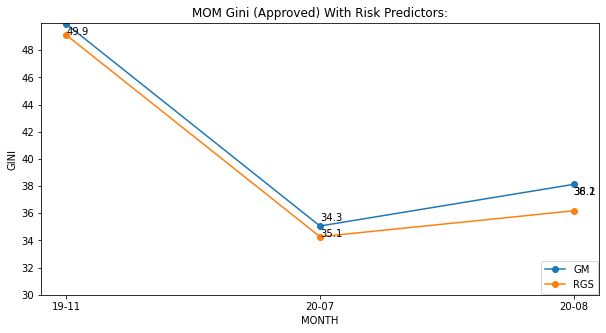

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["GM"], marker='o', scaley = False, label = "GM")
ax1.plot(gini_df["MONTH"],gini_df["RGS"], marker='o', scaley = False, label = "RGS")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM"][i]-0.8))
for i, txt in enumerate(gini_df["RGS"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["RGS"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(30,50)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(30,50,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:")
plt.show()